In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset_folder_name = '/content/drive/MyDrive/UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
"dataframe döndürülür.Görüntüler yinelenir."
    def parse_info_from_file(path):
        
        "veirler tek bir dosyaya ayrıştırıldı."
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,56.0,male,indian,/content/drive/MyDrive/UTKFace/56_0_3_20170119...
1,56.0,male,asian,/content/drive/MyDrive/UTKFace/56_0_2_20170119...
2,56.0,male,indian,/content/drive/MyDrive/UTKFace/56_0_3_20170119...
3,56.0,male,indian,/content/drive/MyDrive/UTKFace/56_0_3_20170119...
4,56.0,male,white,/content/drive/MyDrive/UTKFace/56_0_0_20170119...


In [ ]:
import plotly.express as px
fig = px.histogram(df, x="race", nbins=20)
fig.update_layout(title_text='ırk dağılımı')
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(df, x="gender", nbins=20)
fig.update_layout(title_text='cinsiyet dağılımı')
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='yaş dağılımı')
fig.show()

In [ ]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
  
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
 
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
 
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():

    def make_default_hidden_layers(self, inputs):

        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):

        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
   
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):

        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

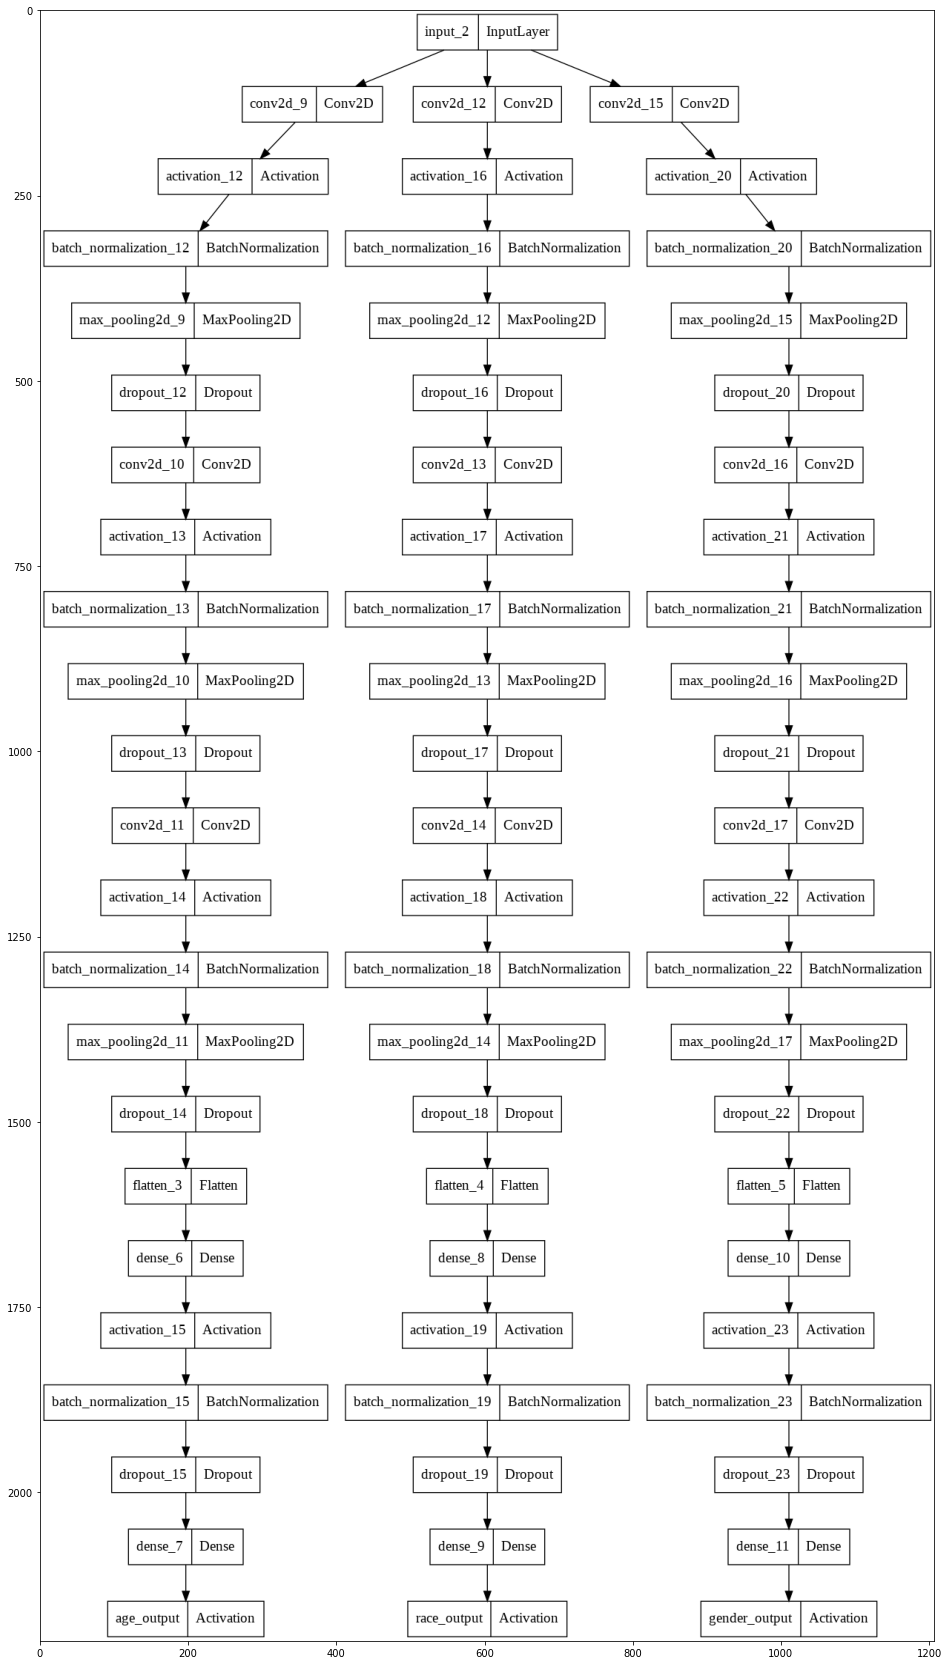

In [ ]:
%matplotlib inline

from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 198, 198, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 198, 198, 16  448         ['input_2[0][0]']                
                                )                                                          

In [ ]:
from tensorflow.keras.optimizers import Adam 

init_lr = 1e-4
epochs = 100

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/100
362/362 [==============================] - 3432s 9s/step - loss: 13.9095 - age_output_loss: 2.7700 - race_output_loss: 1.8428 - gender_output_loss: 0.6542 - age_output_mae: 1.3047 - race_output_accuracy: 0.4135 - gender_output_accuracy: 0.7331 - val_loss: 10.0900 - val_age_output_loss: 1.0390 - val_race_output_loss: 3.9177 - val_gender_output_loss: 0.5730 - val_age_output_mae: 0.7617 - val_race_output_accuracy: 0.4252 - val_gender_output_accuracy: 0.7563
Epoch 2/100
362/362 [==============================] - 97s 268ms/step - loss: 8.9252 - age_output_loss: 1.6984 - race_output_loss: 1.3888 - gender_output_loss: 0.4843 - age_output_mae: 1.0197 - race_output_accuracy: 0.5331 - gender_output_accuracy: 0.8096 - val_loss: 28.7782 - val_age_output_loss: 5.7620 - val_race_output_loss: 3.7901 - val_gender_output_loss: 0.4500 - val_age_output_mae: 1.4943 - val_race_output_accuracy: 0.4875 - val_gender_output_accuracy: 0.8411
Epoch 3/100
362/362 [==============================] - 97s

In [ ]:
model.save('/content/drive/MyDrive/Model/UTKFaceModel.h5')

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_accuracy'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Etnik Kökenlerin Doğruluğu',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mae'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mae'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')

fig.write_html('mae_age.html', include_plotlyjs='cdn')

fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Genel Kayıp',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.write_html('overall_loss.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
test_batch_size = 64
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [ ]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.82      0.90      0.86      3007
       black       0.84      0.81      0.82      1313
       asian       0.81      0.82      0.82      1020
      indian       0.74      0.72      0.73      1206
      others       0.40      0.23      0.30       494

    accuracy                           0.79      7040
   macro avg       0.72      0.70      0.71      7040
weighted avg       0.78      0.79      0.78      7040



In [ ]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.92      0.89      0.91      3678
      female       0.89      0.92      0.90      3362

    accuracy                           0.90      7040
   macro avg       0.90      0.91      0.90      7040
weighted avg       0.91      0.90      0.90      7040



In [ ]:
from sklearn.metrics import r2_score

print('R2 yas degeri: ', r2_score(age_true, age_pred))

R2 score for age:  0.7006210048260674


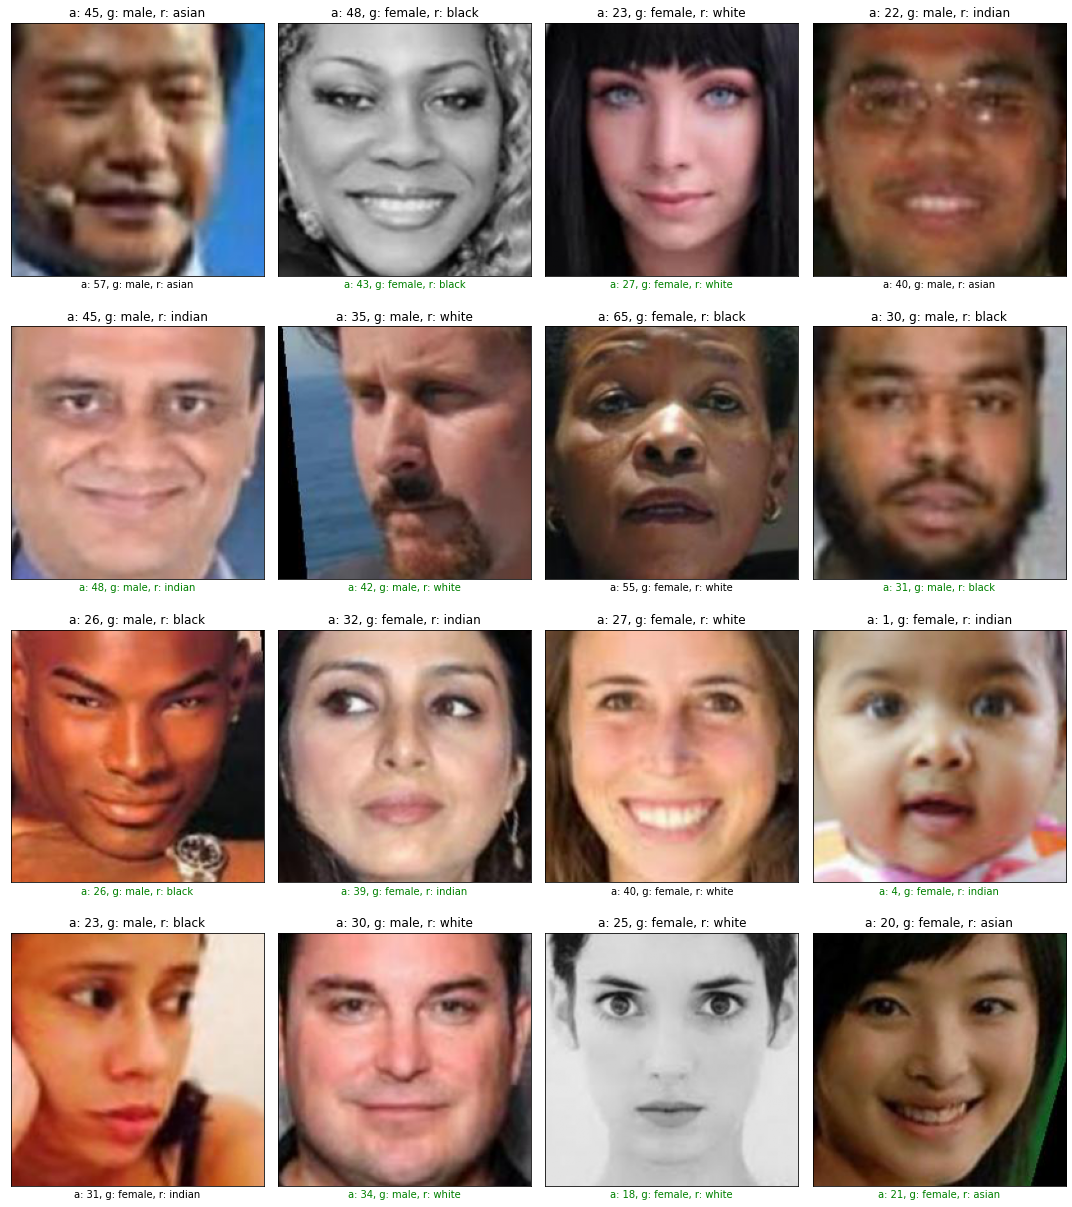

In [ ]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_age_pred = age_pred[img_idx]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx]
    cur_gender_true = gender_true[img_idx]
    
    cur_race_pred = race_pred[img_idx]
    cur_race_true = race_true[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('a: {}, g: {}, r: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx]],
                               dataset_dict['race_id'][race_pred[img_idx]]))
    
    ax.set_title('a: {}, g: {}, r: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx]],
                               dataset_dict['race_id'][race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('preds.png')

In [ ]:
from keras import models  
from keras.models import load_model
model=load_model('/content/drive/MyDrive/Model/UTKFaceModel.h5')